 # ***Transfer Learning***

#### **Students**
André Silva, r20191226@novaims.unl.pt
Corssino Tchavana, 20220597@novaims.unl.pt
Diogo Silva, 20221393@novaims.unl.pt
Lucas Ferreira, 20220621@novaims.unl.pt

#### **Data Source**
Data Source: https://www.kaggle.com/datasets/alessiocorrado99/animals10?select=raw-img

Cleaned dataset: https://drive.google.com/file/d/1Gjui5aea1H49boW3rwzYJ6NBkBQa9qDC/view?usp=sharing


#### **Summary**

This notebook focuses on the application of Transfer Learning, which is the use of pre-trained model as base for a new model trained on a different dataset. 

The pre-trained models used were VGG16, ResNet50 and the previously crafted model CNN7 in the notebook G7_model_handcrafted. For the 3 models, first the model was trained on the dataset, where the layers were untrainable, then Confusion Matrix, F1-score, Accuracy and Recall were calculated for each model's performance.

The same procedure was repeated to each model but now with the modification of the layers would be trainable and the learning rate is decreased, this process is called Fine Tuning.

The model with the best results was VGG16.


#### **References**
* https://keras.io/guides/transfer_learning/
* https://datagen.tech/guides/computer-vision/vgg16/
* https://datagen.tech/guides/computer-vision/resnet-50/
* https://www.youtube.com/watch?v=DyPW-994t7w

## **Import**

In [1]:
!pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 4.2 MB/s eta 0:00:00


In [65]:
# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2, l1
from tensorflow.keras import datasets, layers, initializers, regularizers, optimizers, metrics
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization, Rescaling
from tensorflow.keras.metrics import Precision, AUC, Recall, Accuracy
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam

# Tuning
from kerastuner.tuners import RandomSearch, Hyperband
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

# Data processing
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import shuffle
from tqdm import tqdm

# Utility
import os
import time
import shutil
import random
import zipfile
from google.colab import drive

# Metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

## **Load Dataset**

From the drive mount the zipped dataset is grabbed from the google drived.
The dataset was manipulated into creating a testing folder with 120 images for each category.
The names of the categories were also translated to English (as they were in Italian)


In [4]:
# Set the machine
gdrive = True
# Set the connection string
path_aug = "/content/drive/MyDrive/Trabalho DL/"
main_folder_aug, training_folder, testing_folder = "clean_animals.zip/", "train", "test"
# If using Google Drive
if gdrive:
    # Setup drive
    drive.mount('/content/drive', force_remount=True)        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path_aug + 'clean_animals.zip', 'clean_animals.zip')
    # Extract files
    zip_ = zipfile.ZipFile('clean_animals.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 14.285 seconds


We define some standard parameters to read our train and test folders we just extracted from the zip file.

In [5]:
class_names = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
nb_classes = 10

In [6]:
image_size=(140, 100)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0
shuffle=True
seed=0

In [7]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(
    path + training_folder, 
    image_size=image_size,
    crop_to_aspect_ratio=crop_to_aspect_ratio,
    color_mode=color_mode,
    batch_size=batch_size,
    label_mode=label_mode,
    subset=None,  
    validation_split=validation_split,
    shuffle=shuffle,
    seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 43860 files belonging to 10 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [8]:
# Generate an object of type tf.data.Dataset 
ds_test = image_dataset_from_directory(
    path + testing_folder, 
    image_size=image_size,
    crop_to_aspect_ratio=crop_to_aspect_ratio,
    color_mode=color_mode,
    batch_size=batch_size,
    label_mode=label_mode,
    subset=None,
    validation_split=validation_split,
    shuffle=False,
    seed=seed
)
# Check object properties
print("\nObject's type:\t", type(ds_test))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_test, tf.data.Dataset))
print("Classes:", ds_test.class_names)

Found 3500 files belonging to 10 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [9]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 140, 100, 3) (64, 10)

Sample of x_train: tf.Tensor(
[[192.      221.38   ]
 [188.      218.67143]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 10), dtype=float32)
Sample average of y_train: tf.Tensor(0.1, shape=(), dtype=float32)


In [10]:
iter_test = iter(ds_test)
batch_x_test, batch_y_test = iter_test.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 140, 100, 3) (64, 10)

Sample of x_train: tf.Tensor(
[[192.      221.38   ]
 [188.      218.67143]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 10), dtype=float32)
Sample average of y_train: tf.Tensor(0.1, shape=(), dtype=float32)


## **Metrics Functions**

We want to calculate the metrics for each training model. To facilitate our analysis, we create a function to calculate it and we apply it for each of our models.

In [11]:
def evaluate_model(true_labels, num_classes, predicted_labels):

    # Calculate evaluation metrics
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Store evaluation metrics for each class
    class_metrics = {}
    for i in range(num_classes):
        class_metrics[class_names[i]] = {'precision': precision[i], 'recall': recall[i], 'f1_score': f1_score[i]}
    
    # Print evaluation metrics for each class
    print("{:<20} {:<10} {:<10} {:<10}".format('Class', 'F1-score', 'Accuracy', 'Recall'))
    print("-" * 45)
    for i in range(num_classes):
        class_name = class_names[i]
        f1 = round(class_metrics[class_name]['f1_score'], 2)
        precision = round(class_metrics[class_name]['precision'], 2)
        accuracy = round(accuracy_score([idx==i for idx in true_labels], [idx==i for idx in predicted_labels]), 2)
        print("{:<20} {:<10} {:<10} {:<10}".format(class_name, f1, accuracy, precision))
    
    return accuracy, class_metrics

In [12]:
def plot_confusion_matrix(true_labels, pred_labels):
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

## **Creating the CNN**

Transfer learning is a popular approach in deep learning where a pre-trained model is used as a starting point for a new model trained on a different dataset. The main advantages for it are: **reduced training time**, since the pre-trained model has already learned important features from a large dataset; **improved accuracy**, leveraging the features learned to the new model; and **lower data requirements**, it is possible to achieve high accuracy even with a small dataset, as the pre-trained model has already learned a lot of features from a larger dataset.

The main challenges when using Transfer Learning are to **choose the right pre-trained model** and **limited flexibility**. Since there are a big variety of pre-trained models available, choose the best one for your particular problem can be a tough choice. Also, the pre-trained model and the new model have a similar architecture, which may limit the flexibility of the new model.

### **VGG16**

VGG stands for Visual Geometry Group, the name of the research group that has developed this architecture (as you can see it below).  It consists of 16 layers, with 13 convolutional layers and 3 fully connected layers, and uses small convolutional filters with a size of 3x3.

One of the main advantages of using VGG16 for transfer learning is its simplicity and ease of use. Because it has a uniform architecture with small convolutional filters, it is relatively easy to understand and implement. Another advantage is its strong performance on a wide range of image recognition tasks. Because it was trained on a large dataset of images, it has learned a rich set of features that can be fine-tuned for specific applications with relatively small amounts of data.

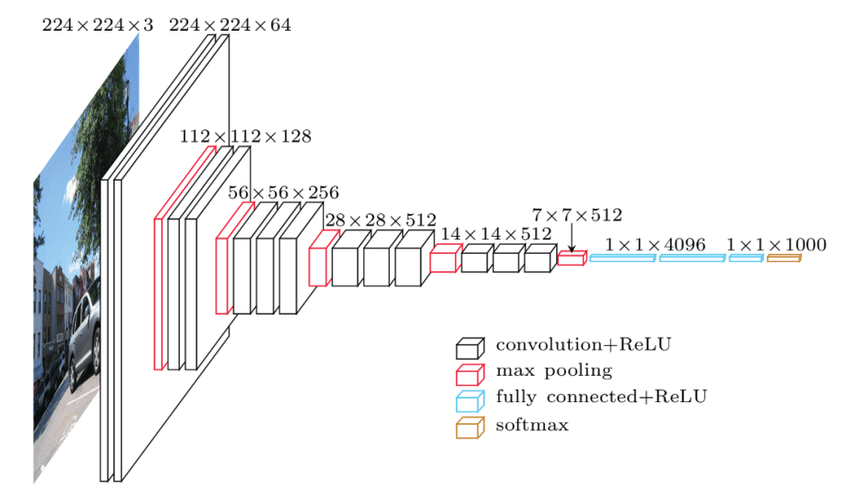

In [24]:
# Create a Sequential model.
model_vgg16 = Sequential()

# Add a Rescaling layer with a scale factor of 1/255 to rescale the pixel values of the input images.
model_vgg16.add(Rescaling(1./255, input_shape=(140, 100, 3)))

# Load the pre-trained VGG16 model with input shape (140,100,3) and exclude the top layers.
base_model_vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(140,100,3))

# Freeze the layers of the pre-trained model to prevent them from being updated during training.
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add the pre-trained VGG16 model to the Sequential model.
model_vgg16.add(base_model_vgg16)

# Add some layers on the top of the base model.
model_vgg16.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Dropout(0.25))
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Dropout(0.5))

# Add a final Dense layer with softmax activation to output probabilities for each of the 10 categories.
model_vgg16.add(Dense(nb_classes, activation='softmax'))

# Print the summary of the model to check the architecture and the number of parameters.
model_vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 140, 100, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 3, 512)         14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 1, 64)          294976    
                                                                 
 batch_normalization_5 (Batc  (None, 2, 1, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 2, 1, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 128)               

In [25]:
# Compile the model with an appropriate loss function, optimizer, and metrics
model_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on your dataset
history_vgg16 = model_vgg16.fit(ds_train, validation_data=ds_test, epochs=10)

Epoch 1/10
686/686 [==============================] - 83s 114ms/step - loss: 1.2143 - accuracy: 0.6413 - val_loss: 0.9516 - val_accuracy: 0.7217
Epoch 2/10
686/686 [==============================] - 72s 105ms/step - loss: 0.8188 - accuracy: 0.7630 - val_loss: 1.0586 - val_accuracy: 0.6894
Epoch 3/10
686/686 [==============================] - 74s 108ms/step - loss: 0.7290 - accuracy: 0.7977 - val_loss: 0.9772 - val_accuracy: 0.7314
Epoch 4/10
686/686 [==============================] - 74s 107ms/step - loss: 0.6838 - accuracy: 0.8148 - val_loss: 1.0080 - val_accuracy: 0.7223
Epoch 5/10
686/686 [==============================] - 74s 108ms/step - loss: 0.6573 - accuracy: 0.8267 - val_loss: 1.0259 - val_accuracy: 0.7226
Epoch 6/10
686/686 [==============================] - 74s 107ms/step - loss: 0.6498 - accuracy: 0.8316 - val_loss: 1.0949 - val_accuracy: 0.7066
Epoch 7/10
686/686 [==============================] - 74s 107ms/step - loss: 0.6478 - accuracy: 0.8342 - val_loss: 1.0847 - val_ac

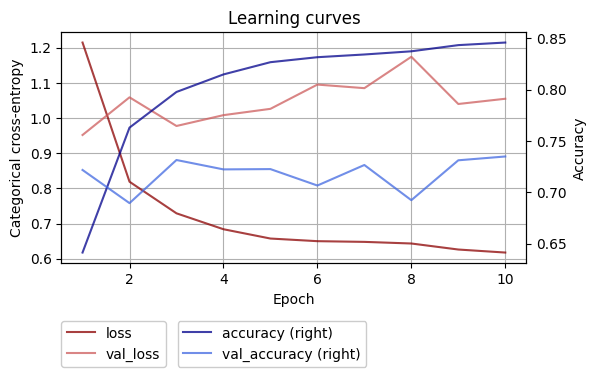

In [26]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history_vgg16.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [27]:
# Evaluate the model on the test set
loss, acc = model_vgg16.evaluate(ds_test)

print('Test Loss:', loss)
print('Test Accuracy:', acc)

55/55 [==============================] - 5s 81ms/step - loss: 1.0546 - accuracy: 0.7349
Test Loss: 1.054582953453064
Test Accuracy: 0.7348571419715881


Confusion Matrix for the model

55/55 [==============================] - 5s 82ms/step


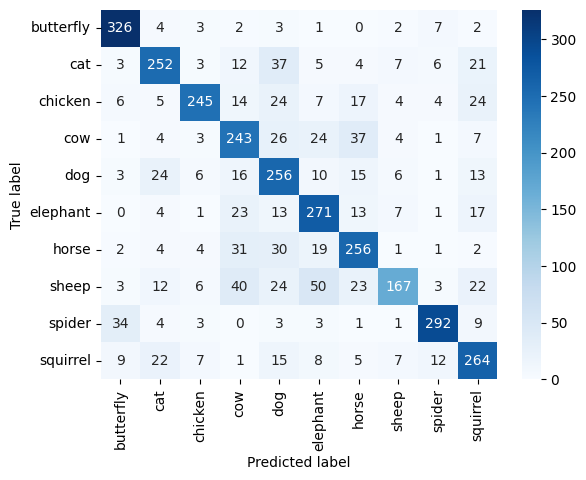

In [28]:
# Predict the classes for the test set
y_pred = model_vgg16.predict(ds_test)

# Convert the predicted class probabilities into class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true class labels for the test set
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

# Call the function we developed to plot the confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels)

We can explore it more checking the metrics for each of the classes.

In [29]:
acc, class_metrics = evaluate_model(y_true_labels, nb_classes, y_pred_labels)

Class                F1-score   Accuracy   Recall    
---------------------------------------------
butterfly            0.88       0.98       0.84      
cat                  0.74       0.95       0.75      
chicken              0.78       0.96       0.87      
cow                  0.66       0.93       0.64      
dog                  0.66       0.92       0.59      
elephant             0.72       0.94       0.68      
horse                0.71       0.94       0.69      
sheep                0.6        0.94       0.81      
spider               0.86       0.97       0.89      
squirrel             0.72       0.94       0.69      


Once done the training, we can try to unfreeze some layers from our base model and reduce the learning rate to check if we get better results. This process is known as fine tuning.

In [30]:
# Unfreeze the last 4 layers of the pre-trained model
for layer in base_model_vgg16.layers[-4:]:
    layer.trainable = True

# Compile the model with an appropriate loss function, optimizer, and metrics
model_vgg16.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

# Fine-tune the model
history_vgg16_fine_tune = model_vgg16.fit(ds_train, epochs=10, validation_data=ds_test)

# Evaluate the model on the test data
loss, acc = model_vgg16.evaluate(ds_test)

print('Test Loss:', loss)
print('Test Accuracy:', acc)

Epoch 1/10
686/686 [==============================] - 84s 116ms/step - loss: 0.5265 - accuracy: 0.8788 - val_loss: 0.9318 - val_accuracy: 0.7631
Epoch 2/10
686/686 [==============================] - 83s 120ms/step - loss: 0.4775 - accuracy: 0.8962 - val_loss: 0.9155 - val_accuracy: 0.7683
Epoch 3/10
686/686 [==============================] - 84s 122ms/step - loss: 0.4430 - accuracy: 0.9096 - val_loss: 0.9023 - val_accuracy: 0.7717
Epoch 4/10
686/686 [==============================] - 84s 122ms/step - loss: 0.4187 - accuracy: 0.9181 - val_loss: 0.8984 - val_accuracy: 0.7731
Epoch 5/10
686/686 [==============================] - 86s 124ms/step - loss: 0.4012 - accuracy: 0.9262 - val_loss: 0.8920 - val_accuracy: 0.7731
Epoch 6/10
686/686 [==============================] - 87s 127ms/step - loss: 0.3852 - accuracy: 0.9298 - val_loss: 0.8911 - val_accuracy: 0.7760
Epoch 7/10
686/686 [==============================] - 87s 127ms/step - loss: 0.3696 - accuracy: 0.9357 - val_loss: 0.8883 - val_ac

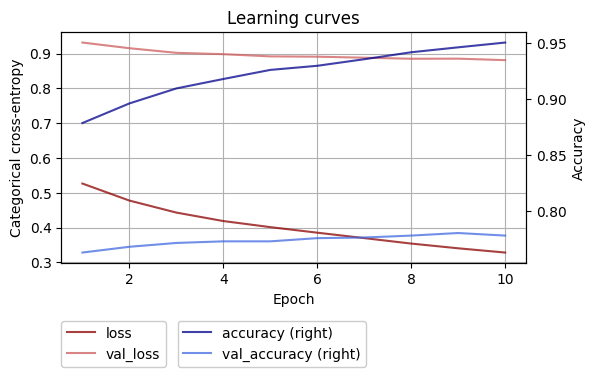

In [31]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history_vgg16_fine_tune.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

55/55 [==============================] - 5s 83ms/step


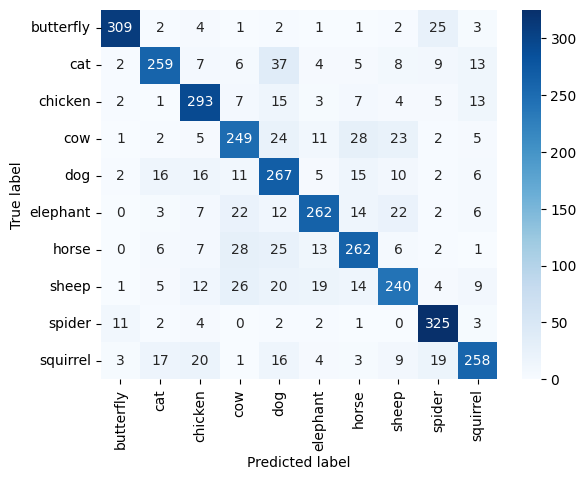

In [32]:
# Predict the classes for the test set
y_pred = model_vgg16.predict(ds_test)

# Convert the predicted class probabilities into class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true class labels for the test set
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

# Call the function we developed to plot the confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels)

In [33]:
acc, class_metrics = evaluate_model(y_true_labels, nb_classes, y_pred_labels)

Class                F1-score   Accuracy   Recall    
---------------------------------------------
butterfly            0.91       0.98       0.93      
cat                  0.78       0.96       0.83      
chicken              0.81       0.96       0.78      
cow                  0.71       0.94       0.71      
dog                  0.69       0.93       0.64      
elephant             0.78       0.96       0.81      
horse                0.75       0.95       0.75      
sheep                0.71       0.94       0.74      
spider               0.87       0.97       0.82      
squirrel             0.77       0.96       0.81      


The results obtained by applying VGG16 are promising, with an accuracy of around 78% on the test data. Future work to further improve this CNN model could involve performing a grid search on the hyperparameters of the network in order to find the optimal combination of values that can result in improved performance.

### **ResNet50**

The original ResNet was ResNet34 (described architecture below) which comprised 34 weighted layers. The ResNet follows the rule to keep the same amount of filters in each layer (if the feature map is halved, the number of filters is doubled in compensation).

In terms of the number of layers and computational complexity, ResNet is more complex than VGG16. ResNet has deeper architectures than VGG16, with 50, 101, or 152 layers, whereas VGG16 has 16 layers.

On the other hand, VGG16 has a more straightforward and uniform architecture, with smaller kernel sizes and the same number of filters in each convolutional layer. This makes it easier to understand and implement.

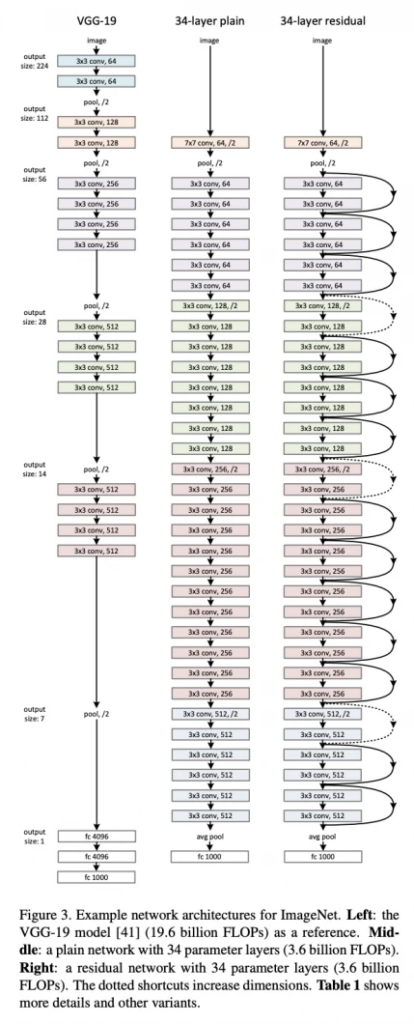

In [59]:
# Create a Sequential model.
model_resnet50 = Sequential()

# Add a Rescaling layer with a scale factor of 1/255 to rescale the pixel values of the input images.
model_resnet50.add(Rescaling(1./255, input_shape=(140, 100, 3)))

# Load the pre-trained ResNet50 model with input shape (140,100,3) and exclude the top layers.
base_model_resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(140,100,3))

# Freeze the layers of the pre-trained model to prevent them from being updated during training.
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Add the pre-trained VGG16 model to the Sequential model.
model_resnet50.add(base_model_resnet50)

# Add some layers on the top of the base model.
model_resnet50.add(Flatten())
model_resnet50.add(Dense(256, activation='relu'))
model_resnet50.add(BatchNormalization())
model_resnet50.add(Dropout(0.5))

# Add a final Dense layer with softmax activation to output probabilities for each of the 10 categories.
model_resnet50.add(Dense(nb_classes, activation='softmax'))

# Print the summary of the model to check the architecture and the number of parameters.
model_resnet50.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 140, 100, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 5, 4, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 40960)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               10486016  
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                      

In [60]:
# Compile the model with an appropriate loss function, optimizer, and metrics
model_resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on your dataset
history_resnet50 = model_resnet50.fit(ds_train, validation_data=ds_test, epochs=10)

Epoch 1/10
686/686 [==============================] - 56s 74ms/step - loss: 1.8757 - accuracy: 0.3563 - val_loss: 5.5723 - val_accuracy: 0.1803
Epoch 2/10
686/686 [==============================] - 53s 77ms/step - loss: 1.6313 - accuracy: 0.4412 - val_loss: 2.7632 - val_accuracy: 0.2666
Epoch 3/10
686/686 [==============================] - 50s 72ms/step - loss: 1.5447 - accuracy: 0.4730 - val_loss: 6.6579 - val_accuracy: 0.1111
Epoch 4/10
686/686 [==============================] - 50s 73ms/step - loss: 1.4848 - accuracy: 0.4961 - val_loss: 3.9183 - val_accuracy: 0.1569
Epoch 5/10
686/686 [==============================] - 51s 75ms/step - loss: 1.4436 - accuracy: 0.5104 - val_loss: 6.1785 - val_accuracy: 0.1429
Epoch 6/10
686/686 [==============================] - 49s 72ms/step - loss: 1.4135 - accuracy: 0.5205 - val_loss: 3.9115 - val_accuracy: 0.1811
Epoch 7/10
686/686 [==============================] - 51s 74ms/step - loss: 1.3659 - accuracy: 0.5390 - val_loss: 3.3896 - val_accuracy:

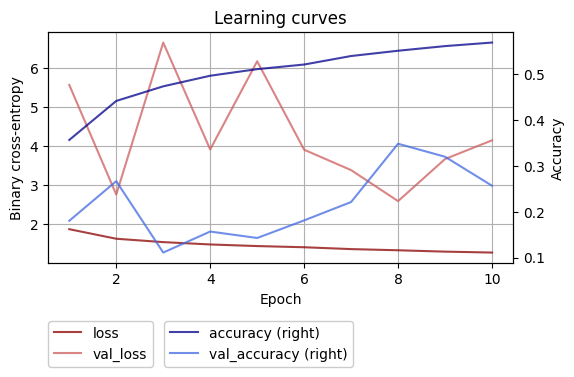

In [61]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history_resnet50.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [62]:
# Evaluate the model on the test set
loss, acc = model_resnet50.evaluate(ds_test)

print('Test Loss:', loss)
print('Test Accuracy:', acc)

55/55 [==============================] - 4s 63ms/step - loss: 4.1523 - accuracy: 0.2566
Test Loss: 4.152286529541016
Test Accuracy: 0.2565714418888092


55/55 [==============================] - 4s 61ms/step


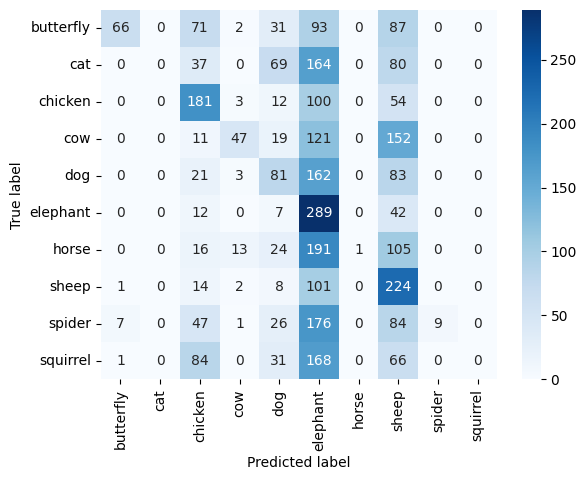

In [63]:
# Predict the classes for the test set
y_pred = model_resnet50.predict(ds_test)

# Convert the predicted class probabilities into class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true class labels for the test set
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

# Call the function we developed to plot the confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels)

In [66]:
acc, class_metrics = evaluate_model(y_true_labels, nb_classes, y_pred_labels)

Class                F1-score   Accuracy   Recall    
---------------------------------------------
butterfly            0.31       0.92       0.88      
cat                  0.0        0.9        0.0       
chicken              0.43       0.86       0.37      
cow                  0.22       0.91       0.66      
dog                  0.25       0.86       0.26      
elephant             0.3        0.62       0.18      
horse                0.01       0.9        1.0       
sheep                0.34       0.75       0.23      
spider               0.05       0.9        1.0       
squirrel             0.0        0.9        0.0       


Fine tuning ResNet50 model

In [67]:
# Unfreeze the last 4 layers of the pre-trained model
for layer in base_model_resnet50.layers[-4:]:
    layer.trainable = True

# Compile the model with an appropriate loss function, optimizer, and metrics
model_resnet50.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

# Fine-tune the model
history_resnet50_fine_tune = model_resnet50.fit(ds_train, epochs=10, validation_data=ds_test)

# Evaluate the model on the test data
loss, acc = model_vgg16.evaluate(ds_test)

print('Test Loss:', loss)
print('Test Accuracy:', acc)

Epoch 1/10
686/686 [==============================] - 59s 79ms/step - loss: 2.3053 - accuracy: 0.2864 - val_loss: 2.1086 - val_accuracy: 0.3157
Epoch 2/10
686/686 [==============================] - 53s 76ms/step - loss: 1.9064 - accuracy: 0.3678 - val_loss: 1.9118 - val_accuracy: 0.3714
Epoch 3/10
686/686 [==============================] - 52s 76ms/step - loss: 1.7621 - accuracy: 0.4063 - val_loss: 1.8089 - val_accuracy: 0.4023
Epoch 4/10
686/686 [==============================] - 55s 80ms/step - loss: 1.6842 - accuracy: 0.4286 - val_loss: 1.7607 - val_accuracy: 0.4203
Epoch 5/10
686/686 [==============================] - 55s 80ms/step - loss: 1.6258 - accuracy: 0.4472 - val_loss: 1.7384 - val_accuracy: 0.4274
Epoch 6/10
686/686 [==============================] - 54s 78ms/step - loss: 1.5815 - accuracy: 0.4618 - val_loss: 1.6935 - val_accuracy: 0.4429
Epoch 7/10
686/686 [==============================] - 55s 79ms/step - loss: 1.5528 - accuracy: 0.4710 - val_loss: 1.6741 - val_accuracy:

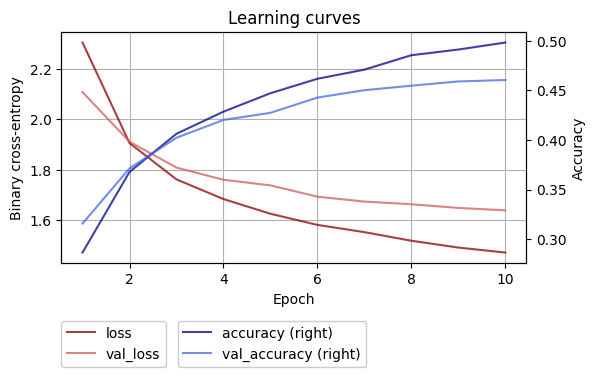

In [68]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history_resnet50_fine_tune.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

55/55 [==============================] - 5s 63ms/step


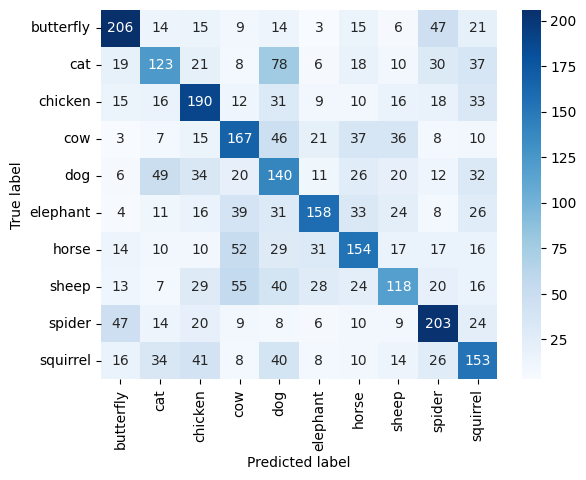

In [69]:
# Predict the classes for the test set
y_pred = model_resnet50.predict(ds_test)

# Convert the predicted class probabilities into class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true class labels for the test set
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

# Call the function we developed to plot the confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels)

In [70]:
acc, class_metrics = evaluate_model(y_true_labels, nb_classes, y_pred_labels)

Class                F1-score   Accuracy   Recall    
---------------------------------------------
butterfly            0.59       0.92       0.6       
cat                  0.39       0.89       0.43      
chicken              0.51       0.9        0.49      
cow                  0.46       0.89       0.44      
dog                  0.35       0.85       0.31      
elephant             0.5        0.91       0.56      
horse                0.45       0.89       0.46      
sheep                0.38       0.89       0.44      
spider               0.55       0.9        0.52      
squirrel             0.43       0.88       0.42      


ResNet50 did not perform as well as VGG16, which could be due to the greater complexity of the ResNet50 model and the difficulty in finding the appropriate hyperparameters for it. Additionally, the CNN may have been overfitting, as the training data achieved higher results than the test data.

### **CNN7**

In the models developed before, CNN7 was the best result achieved in our dataset. In order to compare with the models developed on Transfer Learning, this CNN will be reimplemented and trained. After that, the layers will be frozen in other to also apply Transfer Learning on this network.

In [13]:
# Define the model
cnn7 = Sequential([
    layers.Input(shape=(140, 100, 3)),    
    # Data preprocessing
    layers.Rescaling(1./255), 
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)), # L2 regularization
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.35),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)), # L2 regularization
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l1(0.001)), # L1 regularization
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l1(0.001)), # L1 regularization
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)), # L2 regularization
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


# Compile the model
cnn7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
cnn7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 140, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 138, 98, 64)       1792      
                                                                 
 batch_normalization (BatchN  (None, 138, 98, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 69, 49, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 69, 49, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 47, 128)       7

In [14]:
# Train the model on the dataset
history_cnn7 = cnn7.fit(ds_train, epochs=21, validation_data=(ds_test))

Epoch 1/21
686/686 [==============================] - 93s 115ms/step - loss: 5.0544 - accuracy: 0.2189 - val_loss: 3.1399 - val_accuracy: 0.2440
Epoch 2/21
686/686 [==============================] - 78s 113ms/step - loss: 2.8572 - accuracy: 0.3218 - val_loss: 2.7760 - val_accuracy: 0.3066
Epoch 3/21
686/686 [==============================] - 77s 112ms/step - loss: 2.6057 - accuracy: 0.3914 - val_loss: 2.5029 - val_accuracy: 0.4334
Epoch 4/21
686/686 [==============================] - 77s 112ms/step - loss: 2.4417 - accuracy: 0.4399 - val_loss: 2.4404 - val_accuracy: 0.4274
Epoch 5/21
686/686 [==============================] - 78s 114ms/step - loss: 2.2969 - accuracy: 0.4790 - val_loss: 2.3590 - val_accuracy: 0.4334
Epoch 6/21
686/686 [==============================] - 77s 112ms/step - loss: 2.1335 - accuracy: 0.5122 - val_loss: 2.0782 - val_accuracy: 0.5229
Epoch 7/21
686/686 [==============================] - 77s 112ms/step - loss: 1.9882 - accuracy: 0.5401 - val_loss: 2.5807 - val_ac

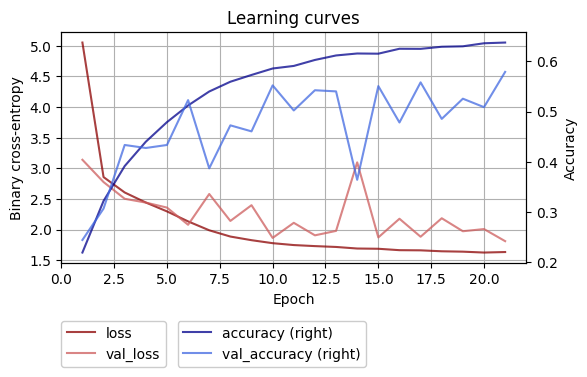

In [15]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history_cnn7.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [16]:
# Freeze the layers of the pre-trained model
for layer in cnn7.layers:
    layer.trainable = False

# Add some layers on the top of the base model.
cnn7.add(Flatten())
cnn7.add(Dense(256, activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(Dropout(0.5))

# Add a final Dense layer with softmax activation to output probabilities for each of the 10 categories.
cnn7.add(Dense(nb_classes, activation='softmax'))

# Print the summary of the model to check the architecture and the number of parameters.
cnn7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 140, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 138, 98, 64)       1792      
                                                                 
 batch_normalization (BatchN  (None, 138, 98, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 69, 49, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 69, 49, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 47, 128)       7

In [17]:
# Compile the model with an appropriate loss function, optimizer, and metrics
cnn7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on your dataset
history_cnn7_transfer = cnn7.fit(ds_train, validation_data=ds_test, epochs=10)

Epoch 1/10
686/686 [==============================] - 29s 39ms/step - loss: 1.8557 - accuracy: 0.5942 - val_loss: 1.8912 - val_accuracy: 0.5631
Epoch 2/10
686/686 [==============================] - 27s 39ms/step - loss: 1.7656 - accuracy: 0.6121 - val_loss: 1.9113 - val_accuracy: 0.5697
Epoch 3/10
686/686 [==============================] - 27s 40ms/step - loss: 1.7557 - accuracy: 0.6115 - val_loss: 1.9086 - val_accuracy: 0.5717
Epoch 4/10
686/686 [==============================] - 29s 43ms/step - loss: 1.7470 - accuracy: 0.6082 - val_loss: 1.8847 - val_accuracy: 0.5751
Epoch 5/10
686/686 [==============================] - 27s 39ms/step - loss: 1.7471 - accuracy: 0.6091 - val_loss: 1.8916 - val_accuracy: 0.5737
Epoch 6/10
686/686 [==============================] - 30s 43ms/step - loss: 1.7412 - accuracy: 0.6100 - val_loss: 1.8734 - val_accuracy: 0.5729
Epoch 7/10
686/686 [==============================] - 27s 39ms/step - loss: 1.7362 - accuracy: 0.6110 - val_loss: 1.8974 - val_accuracy:

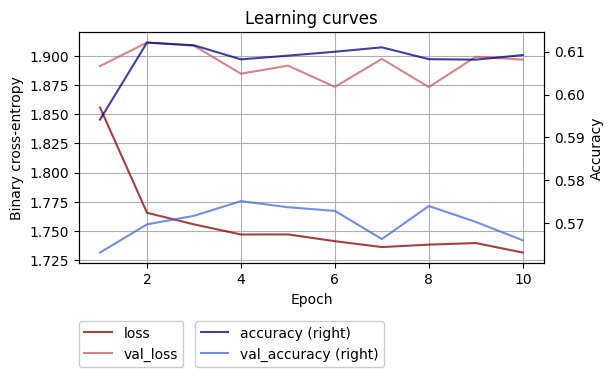

In [18]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history_cnn7_transfer.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [19]:
# Evaluate the model on the test set
loss, acc = cnn7.evaluate(ds_test)

print('Test Loss:', loss)
print('Test Accuracy:', acc)

55/55 [==============================] - 3s 49ms/step - loss: 1.8967 - accuracy: 0.5660
Test Loss: 1.8966925144195557
Test Accuracy: 0.5659999847412109


55/55 [==============================] - 2s 33ms/step


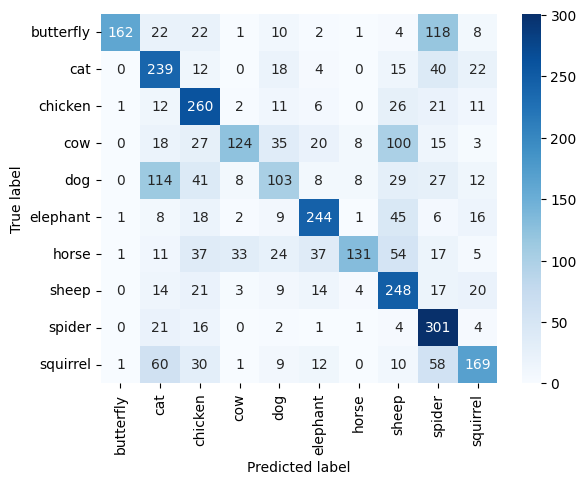

In [20]:
# Predict the classes for the test set
y_pred = cnn7.predict(ds_test)

# Convert the predicted class probabilities into class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true class labels for the test set
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

# Call the function we developed to plot the confusion matrix
plot_confusion_matrix(y_true_labels, y_pred_labels)

In [21]:
acc, class_metrics = evaluate_model(y_true_labels, nb_classes, y_pred_labels)

Class                F1-score   Accuracy   Recall    
---------------------------------------------
butterfly            0.63       0.95       0.98      
cat                  0.55       0.89       0.46      
chicken              0.62       0.91       0.54      
cow                  0.47       0.92       0.71      
dog                  0.36       0.89       0.45      
elephant             0.7        0.94       0.7       
horse                0.52       0.93       0.85      
sheep                0.56       0.89       0.46      
spider               0.62       0.89       0.49      
squirrel             0.55       0.92       0.63      


Unlike the other models, CNN7 didn't improve when applied Transfer Learning. That was expected, since the main advantage of Transfer Learning is to use the features learned from different datasets to apply in the prediction model. Since it is using the same dataset on this task, freezing some layers will most likely only reduce the complexity and capacity from the model.

## Comparing Models

In [71]:
df_results = pd.DataFrame(columns=['name', 'train_acc', 'test_acc'])

In [72]:
train_acc = pd.DataFrame.from_dict(history_vgg16.history).accuracy.iloc[-1]
test_acc = pd.DataFrame.from_dict(history_vgg16.history).val_accuracy.iloc[-1]
df_results = df_results.append({'name': "vgg16", 'train_acc': train_acc, 'test_acc': test_acc}, ignore_index=True)

In [73]:
train_acc = pd.DataFrame.from_dict(history_vgg16_fine_tune.history).accuracy.iloc[-1]
test_acc = pd.DataFrame.from_dict(history_vgg16_fine_tune.history).val_accuracy.iloc[-1]
df_results = df_results.append({'name': "vgg16_fine_tune", 'train_acc': train_acc, 'test_acc': test_acc}, ignore_index=True)

In [74]:
train_acc = pd.DataFrame.from_dict(history_resnet50.history).accuracy.iloc[-1]
test_acc = pd.DataFrame.from_dict(history_resnet50.history).val_accuracy.iloc[-1]
df_results = df_results.append({'name': "resnet50", 'train_acc': train_acc, 'test_acc': test_acc}, ignore_index=True)

In [75]:
train_acc = pd.DataFrame.from_dict(history_resnet50_fine_tune.history).accuracy.iloc[-1]
test_acc = pd.DataFrame.from_dict(history_resnet50_fine_tune.history).val_accuracy.iloc[-1]
df_results = df_results.append({'name': "resnet50_fine_tune", 'train_acc': train_acc, 'test_acc': test_acc}, ignore_index=True)

In [76]:
train_acc = pd.DataFrame.from_dict(history_cnn7.history).accuracy.iloc[-1]
test_acc = pd.DataFrame.from_dict(history_cnn7.history).val_accuracy.iloc[-1]
df_results = df_results.append({'name': "cnn7", 'train_acc': train_acc, 'test_acc': test_acc}, ignore_index=True)

In [77]:
train_acc = pd.DataFrame.from_dict(history_cnn7_transfer.history).accuracy.iloc[-1]
test_acc = pd.DataFrame.from_dict(history_cnn7_transfer.history).val_accuracy.iloc[-1]
df_results = df_results.append({'name': "cnn7_transfer", 'train_acc': train_acc, 'test_acc': test_acc}, ignore_index=True)

In [81]:
df_results

,name,train_acc,test_acc
0,vgg16,0.845828,0.734857
1,vgg16_fine_tune,0.950593,0.778286
2,resnet50,0.568285,0.256571
3,resnet50_fine_tune,0.498404,0.460571
4,cnn7,0.637665,0.579143
5,cnn7_transfer,0.609211,0.566000


## Conclusion

Based on the results obtained, the best CNN model for this particular task was achieved by applying transfer learning on VGG16 and fine-tuning the model. This could be attributed to the simplicity of the VGG16 network architecture, which made it easier to implement and adapt. By fine-tuning the pre-trained VGG16 model on the specific dataset, it was able to adjust the learned features to better fit the data, resulting in improved performance.

On the other hand, the worst results were obtained with ResNet50. It is possible that the complexity of the network made it more difficult to find the best parameters for this specific dataset. Additionally, the difference between training and test results might indicate overfitting in the model.

The CNN7 model developed from scratch had worse results when some layers were frozen and retrained with additional layers. This was to be expected, as the main advantage of transfer learning is the ability to apply features learned on different models to a particular dataset. Applying transfer learning on the same dataset is not a strategic decision, as it loses the main advantages of the technique.